In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from unidecode import unidecode
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
import locale
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import shap
import pickle
from joblib import parallel_backend

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_4_dummy_ohe.csv.gz")
df.head()

,dur_estudio_carr,dur_proceso_tit,desertor_1,prom_notas_media,fscu,gratuidad,beca,dif_ing_ult_mat,edad,valor_arancel,...,tipo_ensenanza_colegio_tp_industrial,tipo_ensenanza_colegio_tp_tecnica,dependencia_colegio_municipal,dependencia_colegio_otro,dependencia_colegio_particular_pagado,dependencia_colegio_particular_subvencionado,area_conoc_inst_adm_hum,area_conoc_inst_ciencias_tec,area_conoc_inst_no_ip,area_conoc_inst_sin_tendencia
0,4,1,1,6.4,0,0,0,0,35,1390000.0,...,0,0,0,0,0,1,0,0,1,0
1,5,1,1,5.5,0,0,1,0,31,1850000.0,...,0,0,0,0,0,1,0,0,0,1
2,6,1,0,4.7,0,0,0,0,29,803000.0,...,0,0,0,0,0,1,0,0,1,0
3,5,1,0,6.0,0,0,0,0,29,1690000.0,...,0,0,1,0,0,0,0,0,0,1
4,5,1,0,6.4,0,0,0,0,16,1480000.0,...,0,0,0,0,0,1,0,0,0,1


In [3]:
df.shape

(885579, 64)

In [4]:
df["desertor_1"].value_counts("%"), df["desertor_1"].value_counts()

(0    0.759669
 1    0.240331
 Name: desertor_1, dtype: float64,
 0    672747
 1    212832
 Name: desertor_1, dtype: int64)

# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["desertor_1"]), df["desertor_1"], random_state=42, test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((797021, 63), (88558, 63), (797021,), (88558,))

In [6]:
pd.Series(y_train).value_counts("%") * 100

0    75.998123
1    24.001877
Name: desertor_1, dtype: float64

# Undersampling

In [7]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled.shape

(382600, 63)

In [8]:
pd.Series(y_resampled).value_counts() 

0    191300
1    191300
Name: desertor_1, dtype: int64

In [9]:
frecuencias = pd.concat([
    X_train.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_train.shape[0] * 100,
    X_resampled.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_resampled.shape[0] * 100,
], axis=1)
frecuencias[np.abs(frecuencias[0] - frecuencias[1]) > 0.5]

,0,1
es_cft_estatal,-67.967594,-66.936226
gen_alu_hombre,50.029171,52.669106
gen_alu_mujer,49.970829,47.330894
tipo_inst_1_centros_de_formacion_tecnica,31.929272,32.957397
tipo_inst_1_institutos_profesionales,68.070728,67.042603
jornada_a_distancia,5.158208,5.678777
jornada_diurno,56.741541,53.146106
jornada_vespertino,37.209810,40.209880
area_conocimiento_salud,13.742423,13.002875
area_conocimiento_tecnologia,33.587321,34.813121


# Modelos

## Regresión Logística

In [10]:
rl = LogisticRegressionCV(cv=10, random_state=42, n_jobs=-1).fit(X_resampled, y_resampled)

In [11]:
print(classification_report(y_test, rl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     67178
           1       0.28      0.55      0.37     21381

    accuracy                           0.56     88559
   macro avg       0.54      0.55      0.52     88559
weighted avg       0.67      0.56      0.59     88559



In [12]:
cr = pd.DataFrame(
    classification_report(y_test, rl.predict(X_test), output_dict=True)
).T.rename(columns={"support": "# Real"})
cr['# Real'] = cr["# Real"].astype(int)
cr["# Predicciones"] = [47242, 41317, 0, 88559, 88559]
cr.index = ["No desertores", "Desertores", "Accuracy", "Macro avg.", "Weighted avg."]
cr.round(2)

,precision,recall,f1-score,# Real,# Predicciones
No desertores,0.80,0.56,0.66,67178,47242
Desertores,0.28,0.55,0.37,21381,41317
Accuracy,0.56,0.56,0.56,0,0
Macro avg.,0.54,0.55,0.52,88559,88559
Weighted avg.,0.67,0.56,0.59,88559,88559


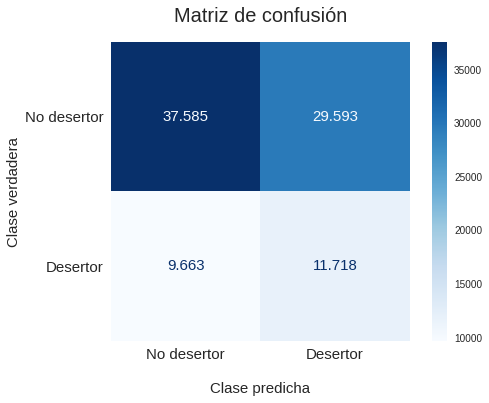

In [13]:
predictions = rl.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rl.classes_)
disp.plot(cmap="Blues", values_format='');
for labels in disp.text_.ravel():
    t = labels.get_text()
    labels.set_text(locale.format_string('%.0f', int(t), grouping=True, monetary=True))
    labels.set_fontsize(15)
plt.grid(False);
plt.title("Matriz de confusión", fontsize=20, pad=20);
plt.ylabel("Clase verdadera", fontsize=15);
plt.xlabel("Clase predicha", fontsize=15, labelpad=20);
plt.yticks([0, 1], ["No desertor", "Desertor"], fontsize=15);
plt.xticks([0, 1], ["No desertor", "Desertor"], fontsize=15);

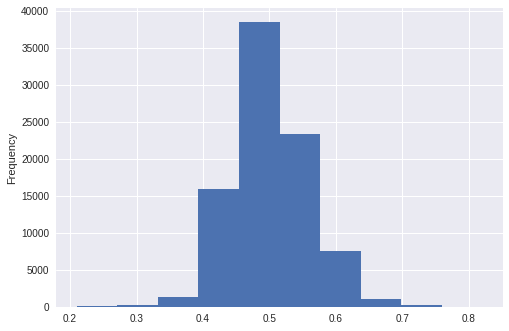

In [14]:
pd.Series(rl.predict_proba(X_test)[:, 1]).plot(kind="hist");

In [15]:
con_proba = df.copy()
con_proba["proba"] = rl.predict_proba(df.drop(columns=["desertor_1"]))[:, 1]

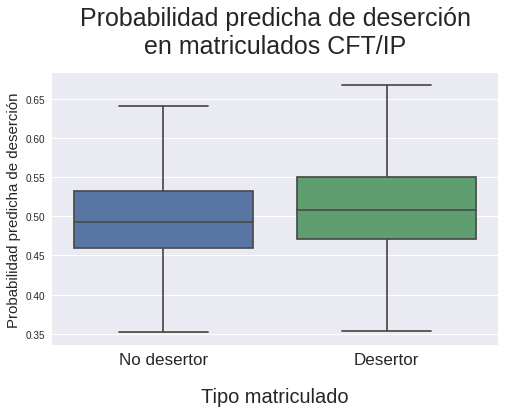

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=con_proba, y="proba", x="desertor_1", showfliers=False);
plt.xticks([0,1], ["No desertor", "Desertor"], fontsize=17);
plt.xlabel("Tipo matriculado", fontsize=20, labelpad=20);
plt.ylabel("Probabilidad predicha de deserción", fontsize=15);
plt.title("Probabilidad predicha de deserción\nen matriculados CFT/IP", fontsize=25, pad=20);

In [17]:
atributos = df.drop(columns=["desertor_1"]).columns
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
logit_1 = smf.logit(f"desertor_1 ~ {' + '.join(atributos)}", data=df_resampled).fit()
coefs = logit_1.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.637797
         Iterations 5


In [18]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] > 0)].sort_values(by=["Coef."], ascending=False)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,3.278874,0.056518,58.014215,0.000000e+00,3.168100,3.389648
area_conocimiento_arte_y_arquitectura,0.319356,0.016682,19.143484,1.096843e-81,0.286660,0.352053
region_sede_los_lagos,0.305977,0.025408,12.042398,2.126814e-33,0.256177,0.355776
acreditada_inst_no_acreditada,0.300911,0.012849,23.418614,2.761908e-121,0.275727,0.326095
region_sede_magallanes,0.273407,0.044522,6.140889,8.206103e-10,0.186145,0.360670
tipo_ensenanza_colegio_otro,0.269981,0.024066,11.218228,3.318538e-29,0.222812,0.317150
region_sede_arica_y_parinacota,0.255230,0.036064,7.077166,1.471321e-12,0.184546,0.325914
region_sede_los_rios,0.250348,0.034043,7.353833,1.926017e-13,0.183625,0.317072
region_sede_lib_gral_b_ohiggins,0.243446,0.025416,9.578594,9.837541e-22,0.193632,0.293260
region_sede_nuble,0.238722,0.030882,7.730000,1.075464e-14,0.178193,0.299250


In [19]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] < 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
valor_arancel,-3.350837e-08,1.053053e-08,-3.182020,1.462518e-03,-5.414783e-08,-1.286890e-08
prom_notas_media,-6.347434e-01,8.820819e-03,-71.959693,0.000000e+00,-6.520319e-01,-6.174549e-01
gratuidad,-5.084477e-01,1.018575e-02,-49.917550,0.000000e+00,-5.284114e-01,-4.884840e-01
beca,-4.283722e-01,8.736973e-03,-49.029811,0.000000e+00,-4.454963e-01,-4.112480e-01
dif_ing_ult_mat,-4.242569e-01,3.549941e-03,-119.510983,0.000000e+00,-4.312147e-01,-4.172992e-01
gen_alu_mujer,-3.001774e-01,8.372773e-03,-35.851608,1.735963e-281,-3.165877e-01,-2.837670e-01
tipo_inst_1_institutos_profesionales,-1.588912e-01,7.750980e-03,-20.499496,2.175357e-93,-1.740828e-01,-1.436995e-01
area_conocimiento_ciencias_sociales,-1.852793e-01,1.678021e-02,-11.041537,2.408771e-28,-2.181679e-01,-1.523907e-01
area_conocimiento_educacion,-7.732841e-02,1.285156e-02,-6.017043,1.776319e-09,-1.025170e-01,-5.213981e-02
area_conocimiento_salud,-6.383634e-02,1.211349e-02,-5.269856,1.365309e-07,-8.757834e-02,-4.009434e-02


## DT

In [20]:
dt = DecisionTreeClassifier(random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72     67178
           1       0.35      0.62      0.45     21381

    accuracy                           0.63     88559
   macro avg       0.60      0.63      0.58     88559
weighted avg       0.72      0.63      0.66     88559



In [10]:
def plot_importance(fit_model, feat_names, n=10):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1][:n]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(n), list(reversed(tmp_importance[sort_importance])))
    plt.yticks(range(n), list(reversed(names)), rotation=0)
    return names

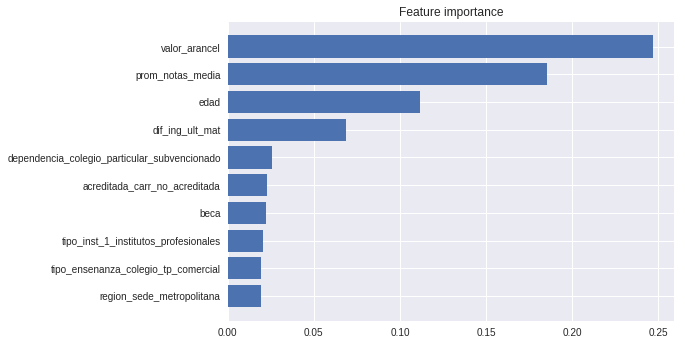

In [22]:
_ = plot_importance(dt, df.drop(columns=["desertor_1"]).columns, n=10)

## XGBoost

In [10]:
clf_pipe = Pipeline(
    steps=[
        ("selection", SelectPercentile(f_classif)),
        ("clf", XGBClassifier(random_state=42))
    ]
)

clf_pipe

Pipeline(steps=[('selection', SelectPercentile()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [11]:
param_grid = {
    "selection__percentile": [80, 95],
    "clf__n_estimators": [50, 100, 250],
    "clf__subsample": [0.5, 1],
    "clf__lambda": [0.5, 1, 2]
}

In [13]:
search = GridSearchCV(
    clf_pipe, param_grid, n_jobs=-1, scoring="f1_macro", cv=10, verbose=10
)

In [14]:
with parallel_backend('multiprocessing'):
    search.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 2/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 3/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 4/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 5/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 6/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 7/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 8/10; 1/36] START clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=80
[CV 5/10; 1/36] END clf__lambda=0.5, clf__n_estimators=50, clf__subsample=0.5, selection_

[CV 2/10; 8/36] START clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=95
[CV 5/10; 7/36] END clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=80;, score=0.692 total time= 3.5min
[CV 3/10; 8/36] START clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=95
[CV 6/10; 7/36] END clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=80;, score=0.693 total time= 3.6min
[CV 4/10; 8/36] START clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=95
[CV 8/10; 7/36] END clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=80;, score=0.692 total time= 3.5min
[CV 5/10; 8/36] START clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=95
[CV 7/10; 7/36] END clf__lambda=0.5, clf__n_estimators=100, clf__subsample=1, selection__percentile=80;, score=0.694 total time= 3.6min
[CV 6/10; 8/36] START clf__lambda=0.

[CV 1/10; 14/36] END clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95;, score=0.688 total time= 3.2min
[CV 9/10; 14/36] START clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95
[CV 10/10; 14/36] START clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95
[CV 3/10; 14/36] END clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95;, score=0.687 total time= 3.3min
[CV 1/10; 15/36] START clf__lambda=1, clf__n_estimators=50, clf__subsample=1, selection__percentile=80
[CV 4/10; 14/36] END clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95;, score=0.687 total time= 3.1min
[CV 2/10; 15/36] START clf__lambda=1, clf__n_estimators=50, clf__subsample=1, selection__percentile=80
[CV 5/10; 14/36] END clf__lambda=1, clf__n_estimators=50, clf__subsample=0.5, selection__percentile=95;, score=0.685 total time= 3.1min
[CV 3/10; 15/36] START clf__lambda=1, c

[CV 7/10; 21/36] START clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80
[CV 10/10; 20/36] END clf__lambda=1, clf__n_estimators=100, clf__subsample=1, selection__percentile=95;, score=0.694 total time= 4.7min
[CV 8/10; 21/36] START clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80
[CV 1/10; 21/36] END clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80;, score=0.690 total time=12.1min
[CV 9/10; 21/36] START clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80
[CV 2/10; 21/36] END clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80;, score=0.693 total time=12.2min
[CV 10/10; 21/36] START clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80
[CV 3/10; 21/36] END clf__lambda=1, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=80;, score=0.690 total time=12.2min
[CV 1/10; 22/36] START clf__

[CV 7/10; 27/36] END clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=80;, score=0.687 total time= 2.1min
[CV 5/10; 28/36] START clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=95
[CV 8/10; 27/36] END clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=80;, score=0.686 total time= 2.1min
[CV 6/10; 28/36] START clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=95
[CV 9/10; 27/36] END clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=80;, score=0.688 total time= 2.1min
[CV 7/10; 28/36] START clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=95
[CV 10/10; 27/36] END clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=80;, score=0.685 total time= 2.1min
[CV 8/10; 28/36] START clf__lambda=2, clf__n_estimators=50, clf__subsample=1, selection__percentile=95
[CV 1/10; 28/36] END clf__lambda=2, clf__n_estimato

[CV 2/10; 35/36] START clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80
[CV 5/10; 34/36] END clf__lambda=2, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=95;, score=0.698 total time=14.3min
[CV 3/10; 35/36] START clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80
[CV 6/10; 34/36] END clf__lambda=2, clf__n_estimators=250, clf__subsample=0.5, selection__percentile=95;, score=0.699 total time=14.5min
[CV 4/10; 35/36] START clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80
[CV 1/10; 35/36] END clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80;, score=0.697 total time=10.8min
[CV 5/10; 35/36] START clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80
[CV 2/10; 35/36] END clf__lambda=2, clf__n_estimators=250, clf__subsample=1, selection__percentile=80;, score=0.699 total time=10.8min
[CV 6/10; 35/36] START clf__lambda=2, cl

In [9]:
search = pickle.load(open("search_xgb.p", "rb"))

In [12]:
search.best_params_

{'clf__lambda': 0.5,
 'clf__n_estimators': 250,
 'clf__subsample': 1,
 'selection__percentile': 95}

In [70]:
x_features = search.best_estimator_[0].fit_transform(X_resampled, y_resampled)
columns = np.asarray(X_resampled.columns.values)
support = np.asarray(search.best_estimator_[0].get_support())
columns_with_support = columns[support]
columns_with_support

array(['dur_estudio_carr', 'dur_proceso_tit', 'prom_notas_media', 'fscu',
       'gratuidad', 'beca', 'dif_ing_ult_mat', 'edad', 'valor_arancel',
       'misma_region', 'es_cft_estatal', 'gen_alu_hombre',
       'gen_alu_mujer', 'tipo_inst_1_centros_de_formacion_tecnica',
       'tipo_inst_1_institutos_profesionales', 'jornada_a_distancia',
       'jornada_diurno', 'jornada_otro', 'jornada_semipresencial',
       'jornada_vespertino', 'region_sede_antofagasta',
       'region_sede_arica_y_parinacota', 'region_sede_atacama',
       'region_sede_biobio', 'region_sede_coquimbo',
       'region_sede_la_araucania', 'region_sede_lib_gral_b_ohiggins',
       'region_sede_los_lagos', 'region_sede_los_rios',
       'region_sede_magallanes', 'region_sede_maule',
       'region_sede_metropolitana', 'region_sede_valparaiso',
       'region_sede_nuble', 'area_conocimiento_administracion_y_comercio',
       'area_conocimiento_agropecuaria',
       'area_conocimiento_arte_y_arquitectura',
       'are

In [80]:
pd.Series(search.predict(X_test)).value_counts()

0    51049
1    37509
dtype: int64

In [81]:
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77     67026
           1       0.42      0.73      0.53     21532

    accuracy                           0.69     88558
   macro avg       0.65      0.70      0.65     88558
weighted avg       0.77      0.69      0.71     88558



In [14]:
print(classification_report(search.predict(X_resampled), y_resampled))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72    180236
           1       0.76      0.72      0.74    202364

    accuracy                           0.73    382600
   macro avg       0.73      0.73      0.73    382600
weighted avg       0.73      0.73      0.73    382600



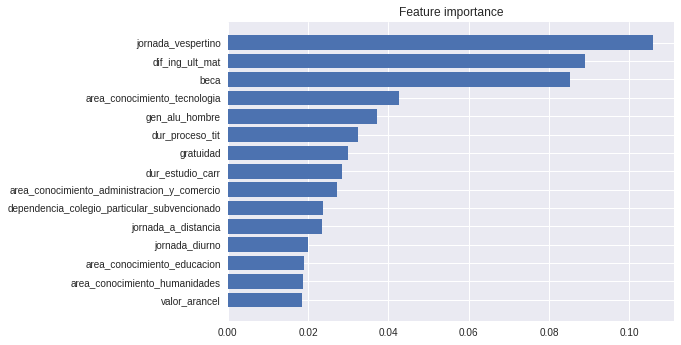

In [27]:
_ = plot_importance(search.best_estimator_[1], df.drop(columns=["desertor_1"]).columns, n=15)

In [83]:
def class_feature_importance(X, Y, feature_importances, n_feats=10):
    sort_importance = np.argsort(feature_importances)[::-1]#[:n_feats]
    feat_names = X.columns
    names = [feat_names[i] for i in sort_importance]
    importancias = feature_importances[sort_importance]
    N, M = X[names].shape
    X = scale(X[names])

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*importancias)
        )

    #return out, names
    t = pd.DataFrame(out)
    t["atributo"] = names
    t["abs"] = t[0].abs()
    return t.sort_values(by=["abs"], ascending=False).head(n_feats).sort_values(by=["abs"])

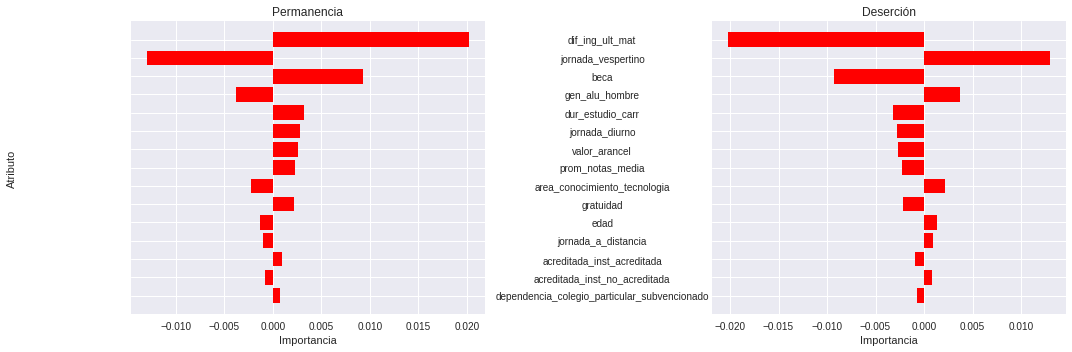

In [84]:
result = class_feature_importance(
    X_resampled, y_resampled, search.best_estimator_[1].feature_importances_, 15
)

titles = ["Permanencia", "Deserción"]
plt.figure(figsize=(15, 5))
for t, i in zip(titles, range(len(set(y_resampled)))):
    ax = plt.subplot(1, 2, i+1)
    plt.title(t)
    plt.barh(
        range(len(result[i])),
        result[i],
        color="r",
        align="center"
    )
    plt.yticks(
        range(len(result[i])),
        result["atributo"] if i == 1 else [""] * result.shape[0],
        rotation=0,
        ha="center"
    )
    plt.xlabel("Importancia")
    if i == 0:
        plt.ylabel("Atributo")
    ax.tick_params(axis='y', which='major', pad=110)
    plt.ylim([-1, len(result[i])])
    
plt.tight_layout()

In [61]:
result["atributo"] = result["atributo"].replace(
    ["dif_ing_ult_mat"], ["años_cursados"]
)

result["atributo"] = [
    a.replace("_", " ").title()
    for a in result["atributo"]
]

Text(0, 0.5, 'Atributo')

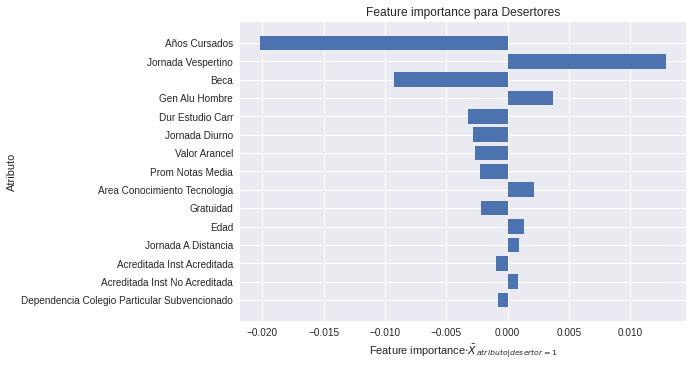

In [63]:
plt.barh(result["atributo"], result[1])
plt.title("Feature importance para Desertores");
plt.xlabel("Feature importance" + r"$\cdot \bar X_{atributo|desertor=1}$");
plt.ylabel("Atributo")

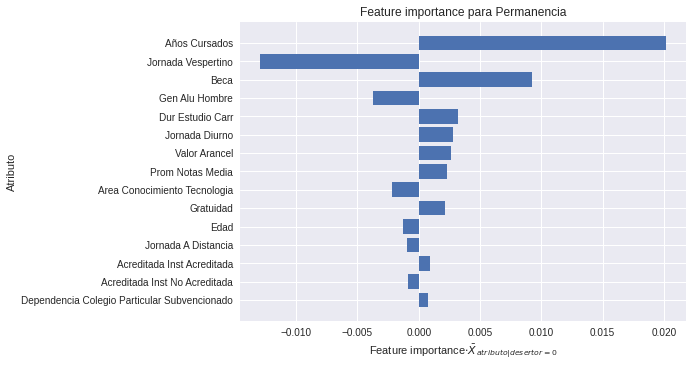

In [65]:
plt.barh(result["atributo"], result[0])
plt.title("Feature importance para Permanencia");
plt.xlabel("Feature importance" + r"$\cdot \bar X_{atributo|desertor=0}$");
plt.ylabel("Atributo");

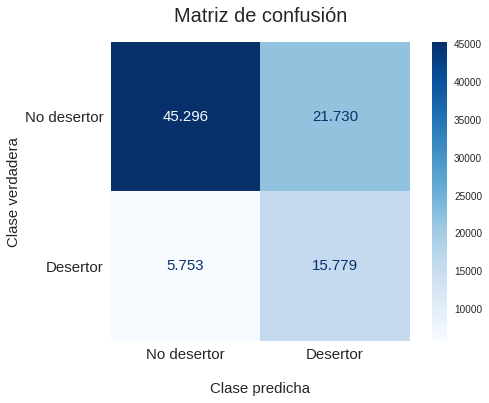

In [89]:
predictions = search.predict(X_test)
clases = search.best_estimator_[1].classes_
cm = confusion_matrix(y_test, predictions, labels=clases)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(cmap="Blues", values_format='');
for labels in disp.text_.ravel():
    t = labels.get_text()
    labels.set_text(locale.format_string('%.0f', int(t), grouping=True, monetary=True))
    labels.set_fontsize(15)
plt.grid(False);
plt.title("Matriz de confusión", fontsize=20, pad=20);
plt.ylabel("Clase verdadera", fontsize=15);
plt.xlabel("Clase predicha", fontsize=15, labelpad=20);
plt.yticks([0, 1], ["No desertor", "Desertor"], fontsize=15);
plt.xticks([0, 1], ["No desertor", "Desertor"], fontsize=15);

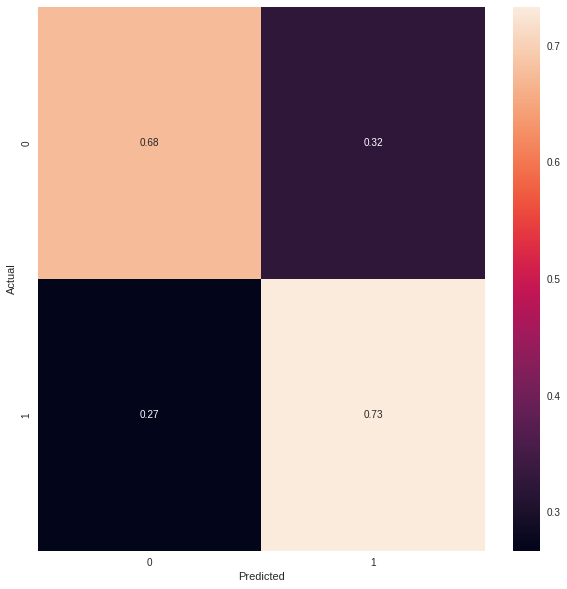

In [90]:
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [98]:
con_proba = X_test.copy()
con_proba["desertor_1"] = y_test
con_proba["proba"] = search.predict_proba(X_test)[:, 1]

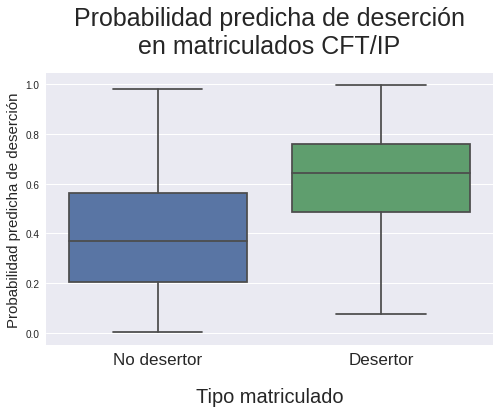

In [99]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=con_proba, y="proba", x="desertor_1", showfliers=False);
plt.xticks([0,1], ["No desertor", "Desertor"], fontsize=17);
plt.xlabel("Tipo matriculado", fontsize=20, labelpad=20);
plt.ylabel("Probabilidad predicha de deserción", fontsize=15);
plt.title("Probabilidad predicha de deserción\nen matriculados CFT/IP", fontsize=25, pad=20);

### Shap values

https://github.com/slundberg/shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [66]:
explainer = shap.TreeExplainer(search.best_estimator_['clf'])
observations = search.best_estimator_['selection'].transform(X_train)

In [67]:
shap_e = explainer(observations)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [68]:
shap_values = explainer.shap_values(observations)

In [72]:
renamed = [
    c.replace("_", " ").title()
    for c in columns_with_support
]

renamed[6] = "Años Cursados"

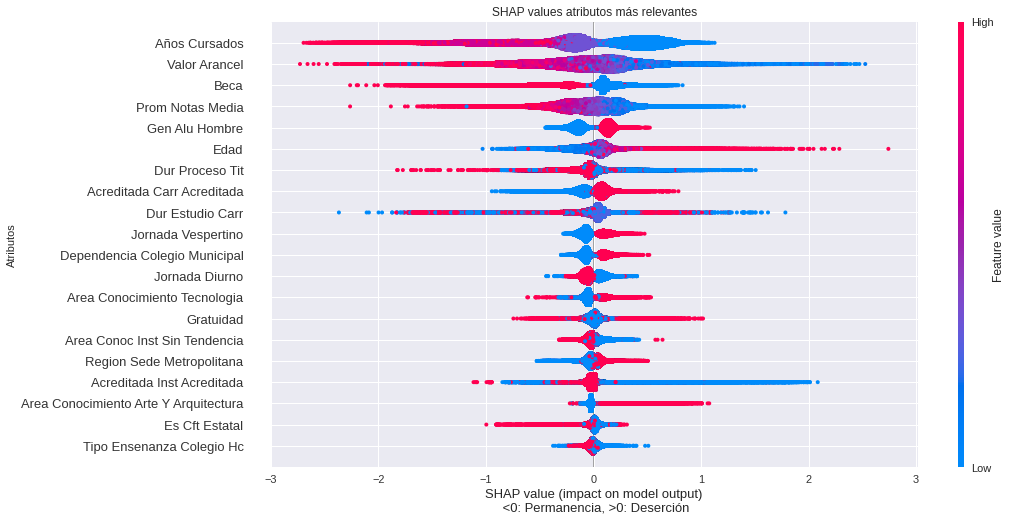

In [75]:
shap.summary_plot(
    shap_values,
    observations,
    class_names=search.best_estimator_['clf'].classes_,
    feature_names=renamed,
    plot_size=[15, 7],
    show=False
)
plt.title("SHAP values atributos más relevantes")
plt.xlabel("SHAP value (impact on model output)\n <0: Permanencia, >0: Deserción")
plt.ylabel("Atributos")
plt.show()

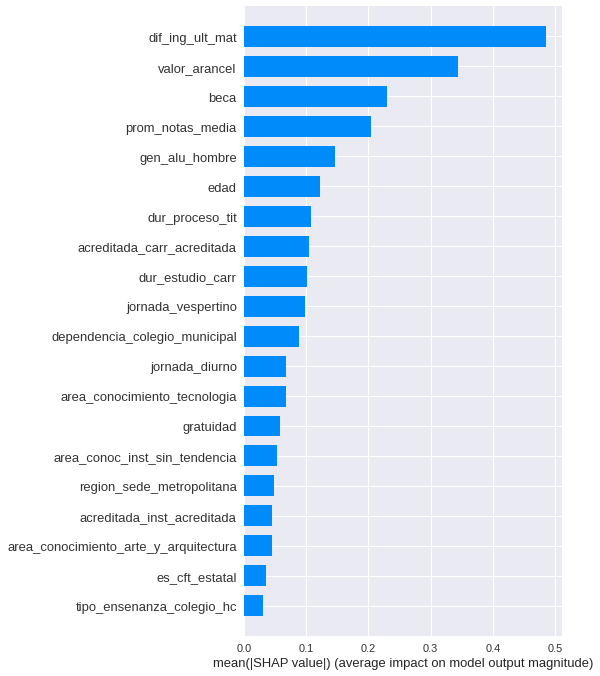

In [29]:
shap.summary_plot(shap_values, observations, plot_type="bar", class_names=search.best_estimator_['clf'].classes_, feature_names=columns_with_support)

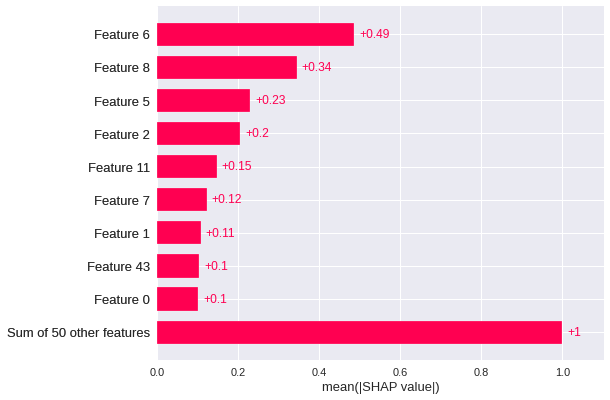

In [34]:
shap.plots.bar(shap_e)

In [31]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [32]:
print_feature_importances_shap_values(shap_values, X_test.columns)

dif_ing_ult_mat -> 0.4860 (softmax = 0.0262)
valor_arancel -> 0.3441 (softmax = 0.0227)
beca -> 0.2293 (softmax = 0.0202)
prom_notas_media -> 0.2049 (softmax = 0.0197)
gen_alu_hombre -> 0.1472 (softmax = 0.0186)
edad -> 0.1224 (softmax = 0.0182)
dur_proceso_tit -> 0.1072 (softmax = 0.0179)
area_conocimiento_humanidades -> 0.1039 (softmax = 0.0178)
dur_estudio_carr -> 0.1008 (softmax = 0.0178)
jornada_vespertino -> 0.0985 (softmax = 0.0178)
tipo_ensenanza_colegio_tp_comercial -> 0.0888 (softmax = 0.0176)
jornada_diurno -> 0.0683 (softmax = 0.0172)
area_conocimiento_educacion -> 0.0672 (softmax = 0.0172)
gratuidad -> 0.0575 (softmax = 0.0170)
dependencia_colegio_particular_subvencionado -> 0.0531 (softmax = 0.0170)
region_sede_maule -> 0.0491 (softmax = 0.0169)
area_conocimiento_tecnologia -> 0.0459 (softmax = 0.0168)
area_conocimiento_administracion_y_comercio -> 0.0449 (softmax = 0.0168)
es_cft_estatal -> 0.0351 (softmax = 0.0167)
acreditada_carr_no_acreditada -> 0.0307 (softmax = 0.01

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [38]:
shap.initjs()
shap.plots.force(shap_e[:100])

## Dummy

In [82]:
aleatorio = DummyClassifier(strategy="stratified", random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, aleatorio.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.50      0.60     67026
           1       0.24      0.50      0.33     21532

    accuracy                           0.50     88558
   macro avg       0.50      0.50      0.47     88558
weighted avg       0.63      0.50      0.54     88558

